In [153]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_laguerre
import sympy
from scipy.optimize import curve_fit

SUM_LIMIT = 375

V_0 = 40 # Potential depth in MeV
a = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_c = 10 # The number of nucleons in the core
ALPHA_I = 0.1
ALPHA_J = 0.1
L = 0

BETA_1 = 0.05
BETA_2 = 0.075
BETA_3 = 0.1
BETA_4 = 0.125
BETA_5 = 0.15 # All in [fm]^-2, and are all initial guesses
BETA_INITIAL_GUESSES = [BETA_1, BETA_2, BETA_3, BETA_4, BETA_5]
INITAL_C_GUESS = 0.01

In [154]:
def polynomial_function(x):
    return x**2


def woods_saxon_integrand(x, potential_depth=V_0, r_0=r_0, diffusivity=a, num_core_nucleons=A_c, alpha_i=ALPHA_I, alpha_j=ALPHA_J):
    R_0 = r_0 * num_core_nucleons**(1/3)
    term_1 = 1 / (1 + np.exp((np.sqrt((x) / (alpha_i + alpha_j)) - R_0) / (diffusivity)))
    term_2 = 1 / (2 * np.sqrt((alpha_i + alpha_j) * x))
    return -V_0 * term_1 * term_2


def second_woods_saxon_intergrand(x, potential_depth=V_0, r_0=r_0, diffusivity=a, num_core_nucleons=A_c, alpha_i=ALPHA_I, alpha_j=ALPHA_J):
    R_0 = r_0 * num_core_nucleons**(1/3)
    term_1 = - potential_depth * np.exp(x - (alpha_i + alpha_j) * x**2)
    term_2 = 1 + np.exp((x - R_0) / diffusivity)
    return term_1 / term_2

$$f(x) = \frac{-V_{0}}{1 + \exp\left(\frac{\sqrt{\frac{x}{\alpha_{i}+\alpha_{j}}} - R_{0}}{a}\right)} \frac{1}{2\sqrt{\left(\alpha_{i}+\alpha_{j}\right)x}}$$

$$g(x) = \frac{-V_{0}e^{r-\left(\alpha_{i}+\alpha{j}\right) r^{2}}}{1+\exp^{\frac{r-R_{0}}{a}}}$$

In [155]:
def gauss_laguerre_quadrature(function, sum_limit=SUM_LIMIT):
    integral_value = 0
    roots, weights = roots_laguerre(sum_limit)
    return np.sum(weights * function(roots))

In [156]:
print(gauss_laguerre_quadrature(woods_saxon_integrand))
# print(gauss_laguerre_quadrature(second_woods_saxon_intergrand))

nan


-53.63893988592332
-65.71518877914879

-61.80248941279764
-65.64001043907666


add spin-orbit term to the form of the potential

In [157]:
def complete_potential(x, R_0, a, V_0, j=0.5, l=0, s=0.5):
    #note: default state is set to s_1/2
    if l % 2 == 0:
        V_ls = 62.52 # [MeV]
    elif l % 2 == 1:
        V_ls = 39.74 # [MeV]
    
    woods_saxon_function = 1 / (1+np.exp(((x-R_0)/a)))
    df_dr = (-1 / (1+np.exp(abs((x-R_0)/a)))**2) * ((1/a)*(np.exp(((x-R_0)/a))))

    woods_saxon_term = -V_0 * woods_saxon_function
    l_dot_s = ((j*(j+1))-(l*(l+1))-(s*(s+1))) / 2
    spin_orbit_term = V_ls * l_dot_s * (1/x) * df_dr

    return woods_saxon_term + spin_orbit_term

In [158]:
test_potential = complete_potential(1, r_0, a, V_0)
print(test_potential)

-23.30280825849259


C:\Users\faola\AppData\Local\Temp\ipykernel_18328\442458874.py:13: RuntimeWarning: divide by zero encountered in divide
  spin_orbit_term = V_ls * l_dot_s * (1/x) * df_dr
C:\Users\faola\AppData\Local\Temp\ipykernel_18328\442458874.py:13: RuntimeWarning: invalid value encountered in multiply
  spin_orbit_term = V_ls * l_dot_s * (1/x) * df_dr


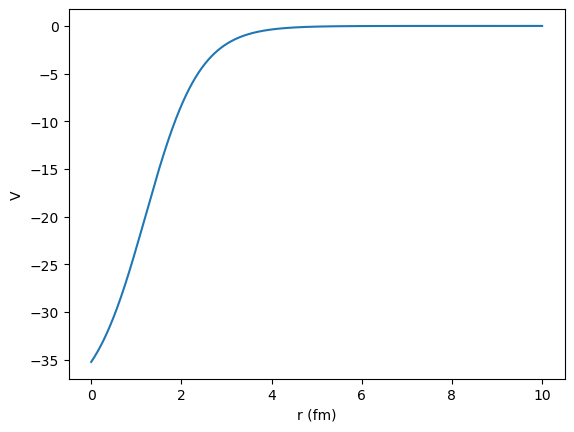

In [159]:
xvals = np.linspace(0, 10, 10000)
fig = plt.figure()

plt.plot(xvals, complete_potential(xvals, r_0, a, V_0))
plt.ylabel('V')
plt.xlabel('r (fm)')
plt.show()

sanity check for df_dr!

In [160]:
def check_derivative():
    x, r, a, V_0, j, l, s = sympy.symbols('x r a V_0 j l s', positive = True)
    woods_saxon_function = 1 / (1+sympy.exp(((x-r)/a)))
    return sympy.Derivative(woods_saxon_function, x).doit()

derivative = check_derivative()
print(derivative)

#derivative.subs({a:0.6, x:5})
derivative.subs([(a, 0.6), (x, 5)])
print(derivative)

-exp((-r + x)/a)/(a*(exp((-r + x)/a) + 1)**2)
-exp((-r + x)/a)/(a*(exp((-r + x)/a) + 1)**2)


test the curve fit for the modified potential

In [161]:
def two_gaussian_potential(r, c_1, beta_1, c_2, beta_2, potential_depth=V_0):
    return -V_0 * (c_1 * np.exp(-beta_1 * r**2) + c_2 * np.exp(-beta_2 * r**2))

In [164]:
r_values = np.linspace(0.0000000000000000001, 12, 1000000)

curve_fit_result, covariances = curve_fit(
        two_gaussian_potential, r_values, complete_potential(r_values, r_0, a, V_0), [INITAL_C_GUESS, BETA_1, INITAL_C_GUESS, BETA_2], maxfev=10000)
print(curve_fit_result)
#note: diagonal elements of the covariance matrix will give the variance on each fit parameter
errors = np.sqrt(np.diag(covariances))
print(errors)

[0.29244253 0.61690031 0.55911349 0.27630213]
[0.00061231 0.00061445 0.00061785 0.00011779]


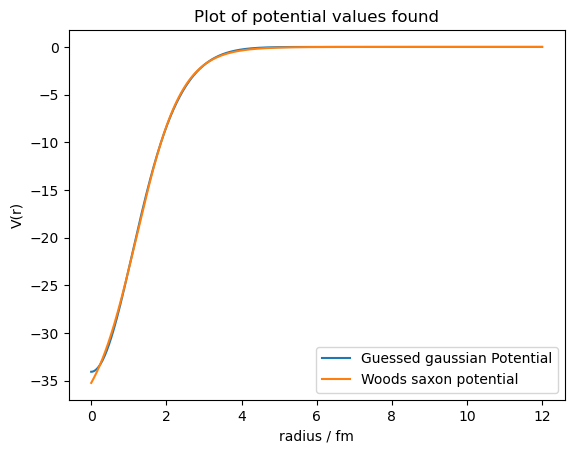

In [167]:
fig = plt.figure()
ax = fig.add_subplot()
x_values = np.linspace(1, 12, 1000)

C_1, BETA_1, C_2, BETA_2 = curve_fit_result

ax.set_title('Plot of potential values found')
ax.set_xlabel('radius / fm')
ax.set_ylabel('V(r)')
# ax.plot(r_values, two_gaussian_potential(r_values, curve_fit_result[0], curve_fit_result[1], curve_fit_result[2], curve_fit_result[3]), label=f'Fited gaussian Potential')
ax.plot(r_values, two_gaussian_potential(r_values, C_1, BETA_1, C_2, BETA_2), label=f'Guessed gaussian Potential')
ax.plot(r_values, complete_potential(r_values, r_0, a, V_0), label='Woods saxon potential')
ax.legend(loc='lower right')

plt.savefig('potentials_plot.png', dpi=300)
plt.show()